# **第六章：Gibbs采样器与后验近似**
Dreisteine, 2021.09.25

## 零、关键点
### **共轭先验分布** 
  * 分布参数的先验分布$p(\theta)$和后验分布$p(\theta|y)$形式一致
  * 共轭先验的好处主要在于代数上的方便性，可以直接给出后验分布的封闭形式，否则的话只能数值计算
  * 共轭先验也有助于获得关于似然函数如何更新先验分布的直观印象

### 正态分布的后验参数估计

参见Chapter 5, 若

$$
y_i \sim \text{normal}(\theta, \sigma^2)
$$

则

$$
\{\theta|y,\sigma^2\} \sim \text{normal}(\frac{\frac{1}{\tau_0^2}\mu_0 + \frac{n}{\sigma^2}\bar y}{1/\tau_0^2+n/\sigma^2}, \frac{1}{1/\tau_0^2 + n/\sigma^2})
$$

相似地也可获得$\{\sigma^2|y, \theta\}$的表达

## **一、基于t检验比较两组独立样本均值**

两个学校学生考试成绩分数样本$x$：

In [1]:
y_1 <- c(1.0, 2.0, 1.1, 2.1, 0.5, 1.9)
y_2 <- c(0.5, 0.6, 7.0, 2.1, 3.3, 4.3, 2.0, 1.5, 2.1)

n_1 <- length(y_1)
n_2 <- length(y_2)

两组样本画图为：

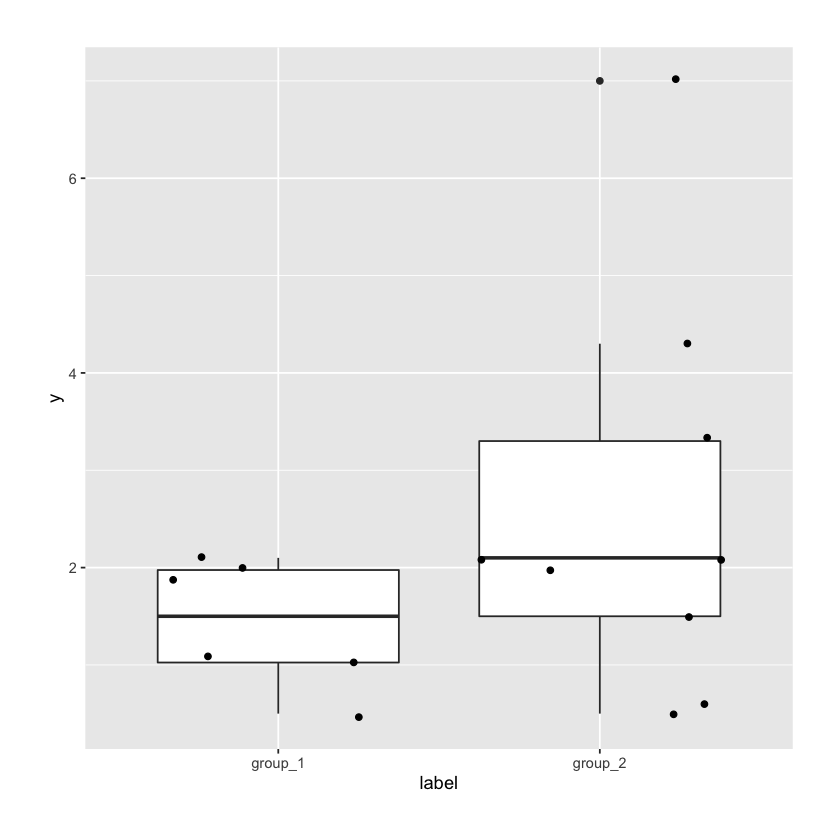

In [2]:
library(ggplot2)
df = data.frame(
  label = c(rep('group_1', times = length(y_1)), rep('group_2', times = length(y_2))), 
  y = c(y_1, y_2)
  )
ggplot(data = df, aes(x = label, y = y)) + geom_boxplot() + geom_jitter() + theme(plot.margin = unit(c(1, 1, 1, 1),"cm"))

使用t对两独立样本进行检验：

In [3]:
results <- t.test(y_1, y_2, alternative = "two.sided", var.equal = FALSE)
t_score <- results[1]$statistic
p_value <- results[3]$p.value

print(p_value)

[1] 0.140333


可见p值为0.14 > 0.05, 因此t检验认为**两组样本来自同一分布**。  
t检验认为:  
* 如果$p<0.05$:  
    $\theta_1 \neq \theta_2$, $\hat \theta_1 = \bar y_1$, $\hat \theta_2 = \bar y_2$;
* 如果$p>0.05$:  
    $\theta_1 = \theta_2$, $\hat \theta_1 = \hat \theta_2 = \frac{\sum_i y_{i,1} + \sum_j y_{j, 2}}{n_1 + n_2}$

对于参数$\theta_1$, 以上基于t检验的估计可以整理为:

$$
\hat \theta_1 = w \bar y_1 + (1 - w) \bar y_2
$$

其中$w=1$如果$p<0.05$, 否则$w=n_1 / (n_1 + n_2)$。可见权重$w$不是连续的。

## **二、基于贝叶斯的参数估计**

在没有观测到任何样本时，我们假设以上两组样本分布分别满足：

$$
Y_{i,1} = \mu + \delta + \epsilon_{i, 1} \\
Y_{j,2} = \mu - \delta + \epsilon_{j, 2} \\
\epsilon_{i, 1} \sim \text{i.i.d. normal}(0, \sigma^2) \\
\epsilon_{i, 2} \sim \text{i.i.d. normal}(0, \sigma^2) \\
$$

其中，

$$
\mu \sim \text{normal}(\mu_0, \gamma_0^2) \\
\delta \sim \text{normal}(\delta_0, \tau_0^2) \\
\sigma^2 \sim \text{inverse-gamma}(\nu_0/2, \nu_0\sigma_0^2/2)
$$

三组参数的先验分布为：

$$
p(\mu, \delta, \sigma^2) = p(u) \times p(\delta) \times p(\sigma^2)
$$

现在已经观测到了两组样本$Y_1$和$Y_2$, 希望通过样本和先验分布求得各参数的后验分布。

令$y_1^{'} =y_1 - \delta, y_2^{'} = y_2 + \delta$，则$y_1^{'}, y_2^{'} \sim \text{normal}(\mu, \sigma^2)$

$$
\{\mu|y_1,y_2,\delta,\sigma^2\} \iff \{\mu|y_1^{'},y_2^{'},\sigma^2\}
$$

所以采用Chapter 5的结论有

$$
\{\mu|y_1,y_2,\delta,\sigma^2\} \sim \text{normal}(\mu_n, \gamma_n^2) \\
$$

$\mu_n, \gamma_n$的具体表达参见Chapter 6对应内容。类似地：

$$
\{\delta|y_1,y_2,\mu,\sigma^2\} \sim \text{normal}(\delta_n^2, \tau_n^2) \\
\{\sigma^2|y_1,y_2,\mu,\delta\} \sim \text{inverse-gamma}(\nu_n/2, \nu_n\sigma_n^2)/2
$$

上面三个式子便构成了该参数估计问题的全条件分布，接下来可进行Monte Carlo采样。

In [4]:
# 先验分布参数.
mu_0 <- 50.0; gamma2_0 <- 625.0
delta_0 <- 0.0; tau2_0 <- 625.0
sigma2_0 <- 100.0; nu_0 <- 1.0

In [5]:
# Gibbs采样.
# 1. mu的后验分布参数.
calGamma2N <- function(sigma2_post){
    gamma2_n <- (1 / gamma2_0 + (n_1 + n_2) / sigma2_post)**(-1)
}

calMuN <- function(gamma2_n, delta_post, sigma2_post){
    A <- mu_0 / gamma2_0
    B <- sum((y_1 - delta_post)/sigma2_post)
    C <- sum((y_2 + delta_post)/sigma2_post)
    mu_n <- gamma2_n * (A + B + C)
}

# 2. delta的后验分布参数.
calTau2N <- function(sigma2_post){
    tau2_n <- (1 / tau2_0 + (n_1 + n_2) / sigma2_post)**(-1)
}

calDeltaN <- function(tau2_n, mu_post, sigma2_post){
    A <- delta_0 / tau2_0
    B <- sum((y_1 - mu_post)/sigma2_post)
    C <- sum((y_2 - mu_post)/sigma2_post)
    delta_n <- tau2_n * (A + B - C)
}

# 3. sigma2的后验分布参数.
calNuN <- function(){
    nu_n <- nu_0 + n_1 + n_2
}

calNuNSigma2N <- function(mu_post, delta_post){
    A <- nu_0 * sigma2_0
    B <- sum((y_1 - (mu_post + delta_post))**2)
    C <- sum((y_2 - (mu_post - delta_post))**2)
    nu_n_sigma2_n <- A + B + C
}

# 后验参数初始值.
mu_post <- mean(mean(y_1), mean(y_2))
delta_post <- (mean(y_2) - mean(y_1)) / 2
sigma2_post <- mean(var(y_1), var(y_2))

# 初始化序列.
MU <- DELTA <- SIGMA2 <- NULL

set.seed(1)
for (s in 1: 10000){
    # mu采样.
    gamma2_n <- calGamma2N(sigma2_post)
    mu_n <- calMuN(gamma2_n, delta_post, sigma2_post)
    mu_s <- rnorm(1, mu_n, sqrt(gamma2_n))
    
    # delta采样.
    tau2_n <- calTau2N(sigma2_post)
    delta_n <- calDeltaN(tau2_n, mu_post, sigma2_post)
    delta_s <- rnorm(1, delta_n, sqrt(tau2_n))
    
    # sigma2采样.
    nu_n <- calNuN()
    nu_n_sigma2_n <- calNuNSigma2N(mu_post, delta_post)
    sigma2_s <- 1/rgamma(1, nu_n / 2, nu_n_sigma2_n / 2)
    
    # 更新后验样本.
    mu_post <- mu_s
    delta_post <- delta_s
    sigma2_post <- sigma2_s
    
    MU <- c(MU, mu_s)
    DELTA <- c(DELTA, delta_s)
    SIGMA2 <- c(SIGMA2, sigma2_s)
}

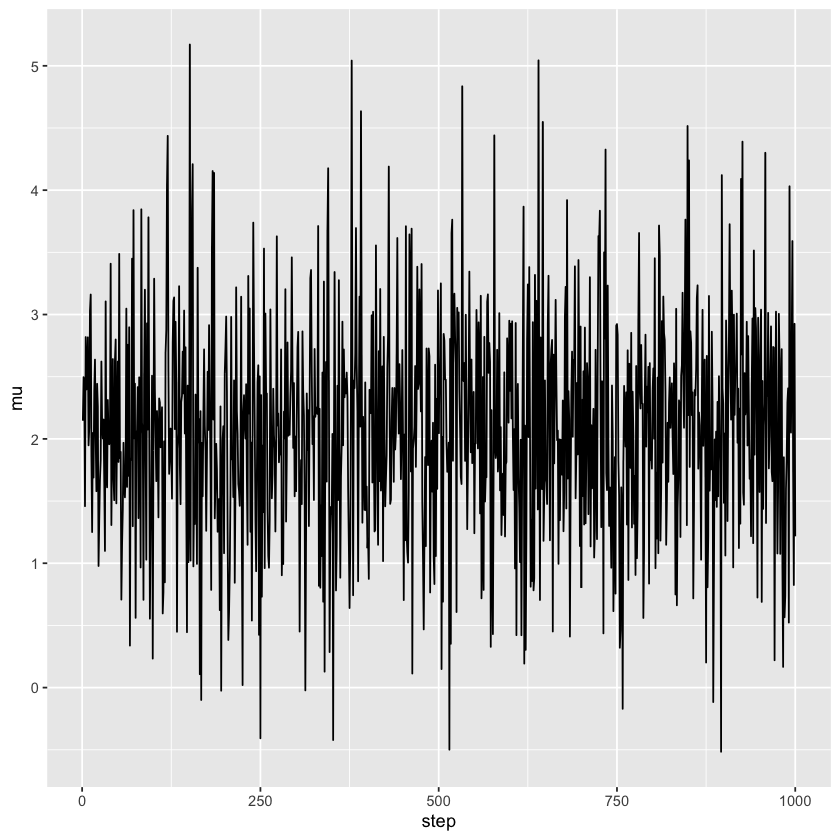

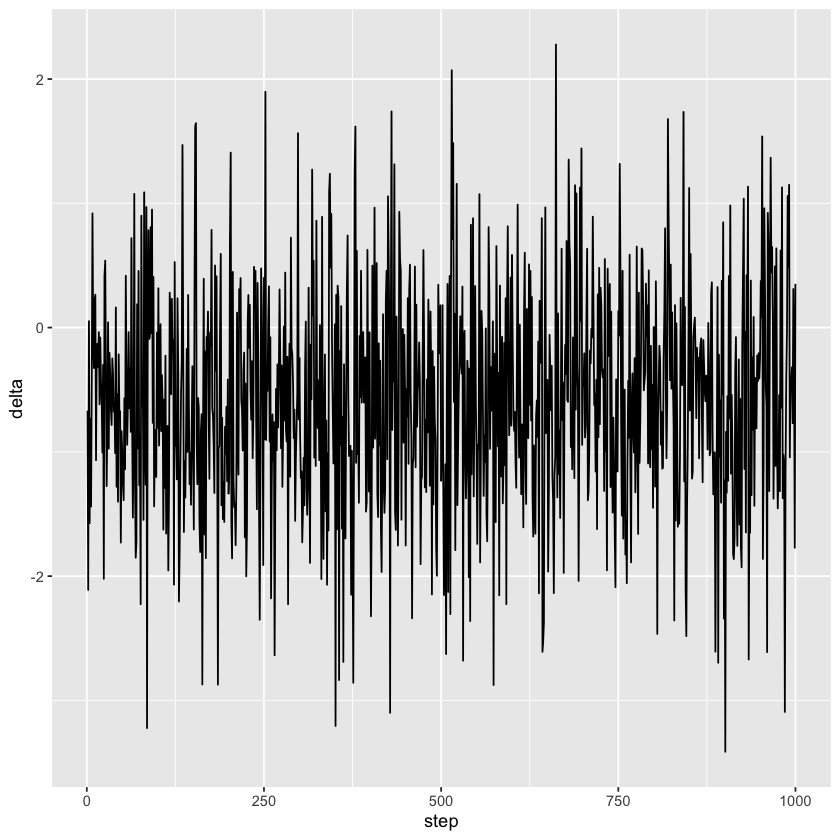

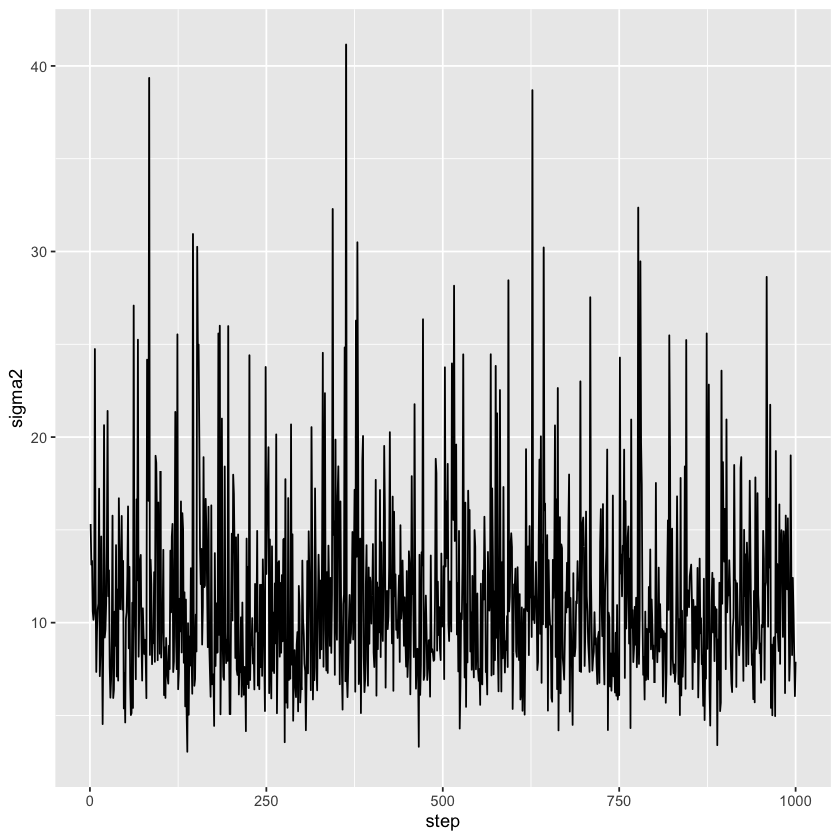

In [53]:
# Gibbs采样过过程.
library(ggplot2)
df = data.frame(mu = MU, delta = DELTA, sigma2 = SIGMA2, step = seq(1, length(MU)))

# 考察Markov迭代过程收敛情况.
par(mfrow=c(1,3)) #将画布分为一行两列
ggplot(data=df[1:1000, ], mapping = aes(x=step, y=mu)) + geom_line()
ggplot(data=df[1:1000, ], mapping = aes(x=step, y=delta)) + geom_line()
ggplot(data=df[1:1000, ], mapping = aes(x=step, y=sigma2)) + geom_line()

In [ ]:
# 联合分布情况.
ggplot(data=df, mapping = aes(x=mu,y=sigma2)) + 
geom_point(size = 3, alpha = 0.1) + 
geom_density2d() + 
theme(plot.margin = unit(c(1, 1, 1, 1),"cm")) 

ggplot(data=df, mapping = aes(x=mu,y=delta)) + 
geom_point(size = 3, alpha = 0.1) + 
geom_density2d() + 
theme(plot.margin = unit(c(1, 1, 1, 1),"cm"))